In [1]:
%load_ext autoreload
%autoreload 2

# VGG

[VGG](https://arxiv.org/abs/1409.1556) won the Imagenet competition in 2014 and it introduced some key concepts that are still used today. The main idea is to use a stack of convolutional layers with small filters (3x3) that don't change the spatial resolution of the input feature maps, followed by max pooling layers wich reduce the dimensionality by half. Also, every time the dimensions are reduced, the number of filters in the next layers are doubled. 

![vgg](pics/vgg.png)

In [2]:
import torch
import torch.nn as nn
from torch.nn import Sequential as S 
from torch.nn import Conv2d as C
from torch.nn import ReLU as R 
from torch.nn import MaxPool2d as M

vgg11config = [
    {'repeat': 1, 'filters': 64},
    {'repeat': 1, 'filters': 128},
    {'repeat': 2, 'filters': 256},
    {'repeat': 2, 'filters': 512},
    {'repeat': 2, 'filters': 512},
]

def vgg_block(r, f1, f2):
    return S(*[S(C(f1 if i == 0 else f2,f2,3,1,1),R()) for i in range(r)],M(2,2))

class VGG(nn.Module):
    def __init__(self, conf):
        super(VGG, self).__init__()
        self.backbone = S(*[vgg_block(r['repeat'], conf[i-1]['filters'] if i > 0 else 3, r['filters']) for i, r in enumerate(conf)])
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(7, 7)), # makes it work with any input size (useful for testing at 256x256)
            nn.Flatten(),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        return self.head(self.backbone(x))

In [3]:
x = torch.randn(1, 3, 224, 224)
model = VGG(vgg11config)
model(x).shape

torch.Size([1, 1000])

These are the hyperparameters used in the original paper:

In [4]:
from convnets.datasets import ImageNet
import albumentations as A
from convnets.train import seed_everything
from torch.utils.data import DataLoader
from convnets.train import fit 
from convnets.metrics import error, top5_error
import lightning as L

seed_everything()

trans = A.Compose([
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.RGBShift()
])

path = '/fastdata/imagenet256' 
dataloaders  =  {
    'train': DataLoader(ImageNet(path, 'train', trans), batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(ImageNet(path, 'val'), batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

model = VGG(vgg11config)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.1, verbose=True, threshold_mode='abs', min_lr=1e-5)
criterion = nn.CrossEntropyLoss()
metrics = {'t1err': error, 't5err': top5_error}

class Callback:
    def after_val(self, val_logs):
        scheduler.step(val_logs['t1err'][-1])

fabric = L.Fabric(accelerator="gpu", devices=1, precision='bf16-mixed', callbacks=[Callback()])

hist = fit(
    model, 
    dataloaders, 
    optimizer, 
    criterion,
    metrics, 
    max_epochs=10, # original paper says 74 epochs 
    fabric=fabric,
    limit_train_batches=100, # comment to train on full dataset
    limit_val_batches=100 # comment to validate on full dataset
)


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resource

Number of trainable parameters: 132863336
Compiling model ...


[2023-03-25 08:24:14,135] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch 00003: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


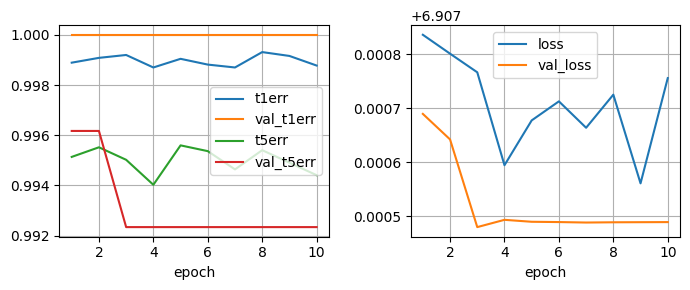

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['t1err', 'val_t1err', 't5err', 'val_t5err'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()


Originally, it took about 2-3 weekas on four NVIDIA Titan Black GPUs to train the model. 